In [1]:
import logging
import sys

import IPython
import numpy as np
import pandas
import scipy
import scipy.stats
import statsmodels
import statsmodels.tsa
import statsmodels.tsa.stattools
import matplotlib
import matplotlib.pyplot as plt


logging.basicConfig()
lg = logging.getLogger()
lg.setLevel(logging.INFO)
lg.handlers[0].setFormatter(logging.Formatter("%(asctime)s.%(msecs)03d %(pathname)s:%(lineno)d %(message)s", datefmt="%Y-%m-%d %H:%M:%S"))

/home/shaoyu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


66              date    price   returns  absreturn  survival
9489   1987-10-27  2836.92 -0.471309   0.471309  0.014925
8679   1990-08-27  3378.00 -0.393753   0.393753  0.029851
8751   1990-05-30  6857.00 -0.258532   0.258532  0.044776
13251  1974-11-07   197.27 -0.254138   0.254138  0.059701
3837   2008-10-23  4730.51 -0.247814   0.247814  0.074627
Taiwan stock index N 864 MS 0.25
62              date    price   returns  absreturn  survival
7851   1987-10-28   233.28 -0.340988   0.340988  0.015873
2559   2008-10-22   896.78 -0.302264   0.302264  0.031746
2469   2009-03-04   712.87 -0.171043   0.171043  0.047619
11109  1974-12-06    65.01 -0.144945   0.144945  0.063492
4341   2001-09-25  1012.27 -0.138025   0.138025  0.079365
S&P500 stock index N 964 MS 0.46
Gaussian with same σ as TAIEX mean 0.000347 stdev 0.014374
Gaussian with same σ as TAIEX N 864 MS 0.05


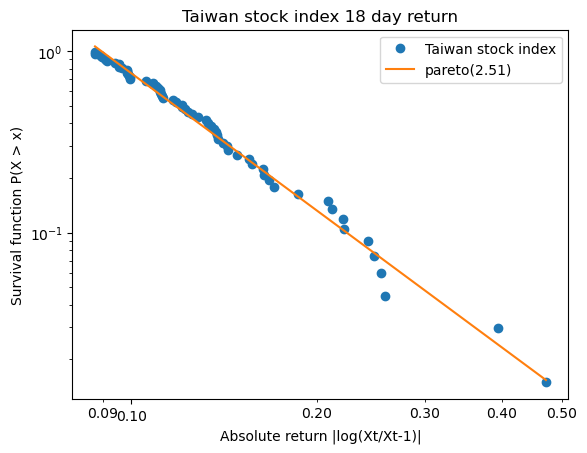

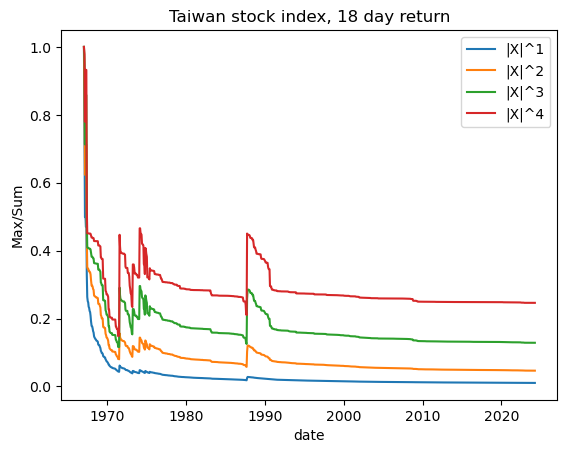

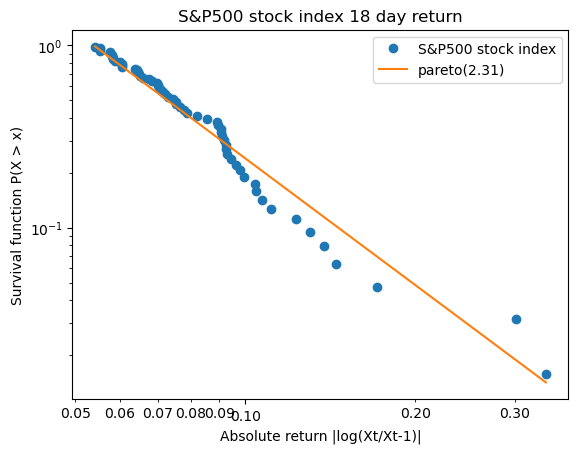

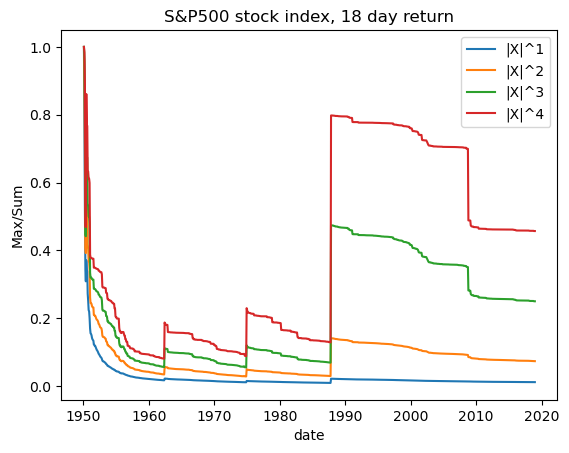

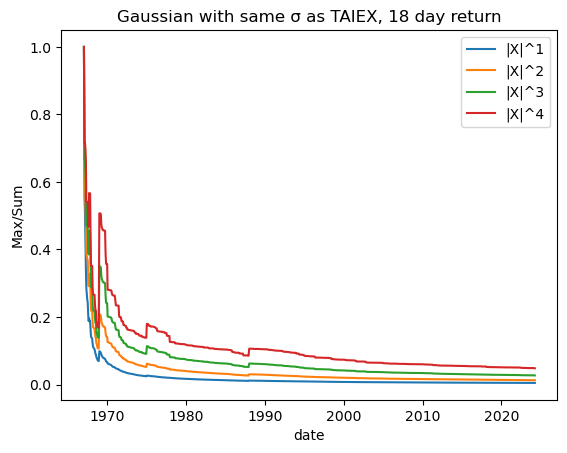

In [16]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def tailLinReg(x, y):
    # Sort data.
    data = np.stack([x, y], axis=1)
    data = data[data[:, 0].argsort()]

    # Give more weight to tail.
    last = data[len(data)-1]
    for i in range(int(data.shape[0]*0.1)):
        data = np.append(data, [last], axis=0)

    lr = scipy.stats.linregress(data[:, 0], data[:, 1])
    return lr


def analyzePareto(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    # df["returns"] = df.price / df.price.shift(-analysis.lag)-1
    # df.drop(df.tail(analysis.lag).index,inplace=True)
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]

    df = df.sort_values(by='date', ascending=False)
    df["returns"] = df.price / df.price.shift(-1)-1
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]
    if len(df) == 0:
        return
    
    df = df.sort_values(by='absreturn', ascending=False)
    df["survival"] = 1-(df.absreturn.rank()-1) / len(df)
    df["survival"] = (np.arange(len(df))+1)/len(df)
    df = df.iloc[:-1]
    
    # Maximum likelihood method. 
    xm = np.min(df.absreturn)
    alpha = len(df)/np.sum(np.log(df.absreturn/xm))

    # Linear regression method.
    lr = tailLinReg(np.log(df.absreturn), np.log(df.survival))
    alpha = -lr.slope
    xm = np.power(np.exp(lr.intercept), 1/alpha)

    # Scipy method.
    # scipyPareto = scipy.stats.pareto.fit(df.absreturn, scale=analysis.lag*0.02)
    # scipyAlpha = scipyPareto[0]

    fitted = np.power(xm/df.absreturn, alpha)
    
    print(len(df), df.head(5))
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.absreturn.to_numpy(), df.survival.to_numpy(), "o", label=analysis.name)
    ax.plot(df.absreturn.to_numpy(), fitted.to_numpy(), label=("pareto(%.2f)"%(alpha)))
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.set_title("%s %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("Absolute return |log(Xt/Xt-1)|")
    ax.set_ylabel("Survival function P(X > x)")
    # fig.savefig("loglog_%s"%analysis.name)


def analyzeMSp(df, p):
    df["Xp%d" % p] = np.power(df.absreturn, p)

    df["msMax%d" % p] = df["Xp%d" % p].cummax()
    if False:
        k = 10
        for i in range(len(df)):
            subset = df.iloc[:i+1]
            vs = subset["Xp%d" % p].to_numpy().copy()
    
            vs = np.sort(vs)
            largest = vs[max(0, len(vs)-k):]
            mx = np.sum(largest)
    
            df.iloc[i, df.columns.get_loc("msMax%d" % p)] = mx
            
    
    df["msSum%d" % p] = df["Xp%d" % p].cumsum()
    df["ms%d" % p] = df["msMax%d" % p] / df["msSum%d" % p]


def plotMS(analysis, df):
    fig, ax = plt.subplots(1, 1)
    for p in [1, 2, 3, 4]:
        analyzeMSp(df, p)
        x = matplotlib.dates.date2num(df.date)
        y = df["ms%d" % p].to_numpy()
        x = x[0:]
        y = y[0:]
        ax.plot_date(x, y, fmt="-", label=("|X|^%d" % p))
    ax.legend()
    ax.set_title("%s, %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("date")
    ax.set_ylabel("Max/Sum")
    # fig.savefig("ms_%s"%analysis.name)
    print("%s N %d MS %.2f" % (analysis.name, len(df), df.iloc[len(df)-1]["ms4"]))


def analyzeMS(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(1))
    df.drop(df.head(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))

    plotMS(analysis, df)
    #df.to_csv("qqq.csv")


def analyze(analysis):
    analyzePareto(analysis)
    analyzeMS(analysis)


# Plot a MS-plot for a normal distribution corresponding to TAIEX.
def ms_taiex_gaussian(lag):
    analysis = Analysis()
    analysis.name = "Gaussian with same σ as TAIEX"
    analysis.lag = lag
    
    # Compute daily standard deviation
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    mean = np.mean(df.returns)
    std = np.std(df.returns)
    print("%s mean %f stdev %f" % (analysis.name, mean, std))
    
    # Simulate a normal distribution using the computed standard deviation.
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df["returns"] = np.random.normal(loc=0, scale=std, size=len(df))
    for i in range(len(df)):
        if i == 0:
            continue
        lastPrice = df.iloc[i-1].price
        returnI = np.exp(df.iloc[i].returns)
        df.iloc[i, df.columns.get_loc("price")] = lastPrice*returnI

    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(1))
    df.drop(df.head(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    plotMS(analysis, df)


analysisLag = 18
for lag in [analysisLag]:
    for tailCutoff in [0.0047]:
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analyze(analysis)
        
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.tailCutoff = 0.003
        analyze(analysis)
ms_taiex_gaussian(analysisLag)

gaussian variance: 1.000000
gaussian run 0
gaussian run 100
gaussian run 200
gaussian run 300
gaussian run 400
gaussian run 500
gaussian run 600
gaussian run 700
gaussian run 800
gaussian run 900
gaussian run 1000
gaussian run 1100
gaussian run 1200
gaussian run 1300
gaussian run 1400
gaussian run 1500
gaussian run 1600
gaussian run 1700
gaussian run 1800
gaussian run 1900
gaussian run 2000
gaussian run 2100
gaussian run 2200
gaussian run 2300
gaussian run 2400
gaussian run 2500
gaussian run 2600
gaussian run 2700
gaussian run 2800
gaussian run 2900
gaussian run 3000
gaussian run 3100
gaussian run 3200
gaussian run 3300
gaussian run 3400
gaussian run 3500
gaussian run 3600
gaussian run 3700
gaussian run 3800
gaussian run 3900
gaussian run 4000
gaussian run 4100
gaussian run 4200
gaussian run 4300
gaussian run 4400
gaussian run 4500
gaussian run 4600
gaussian run 4700
gaussian run 4800
gaussian run 4900
gaussian run 5000
gaussian run 5100
gaussian run 5200
gaussian run 5300
gaussian run

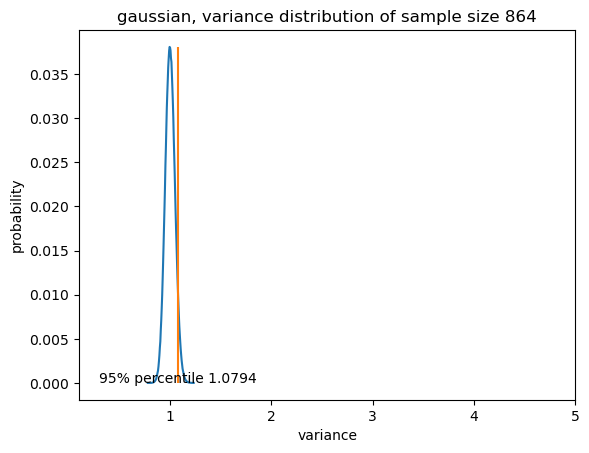

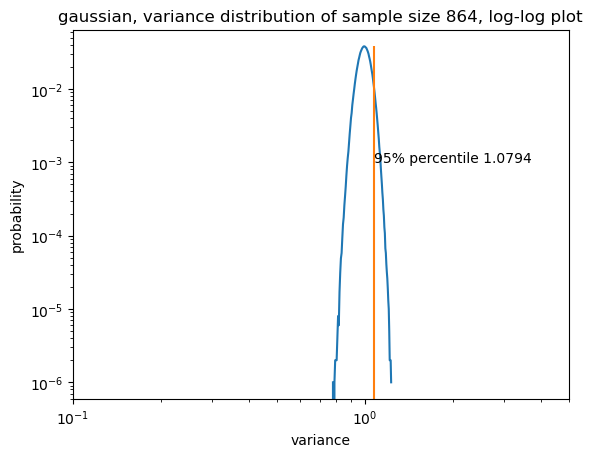

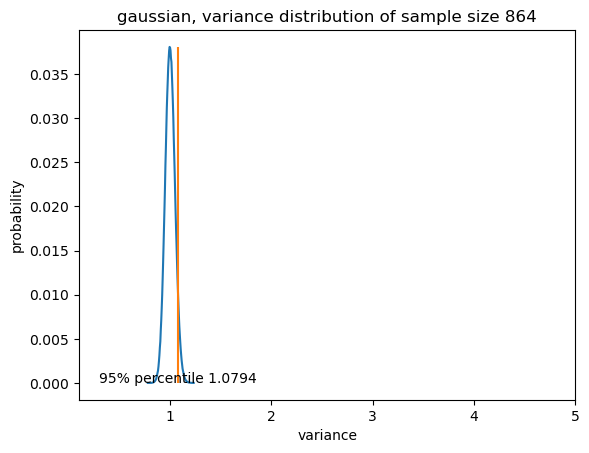

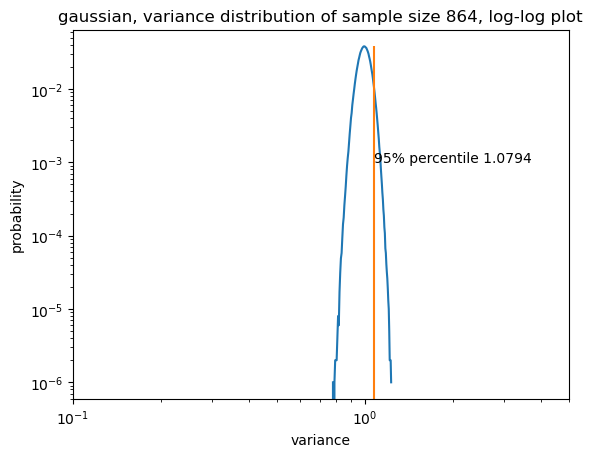

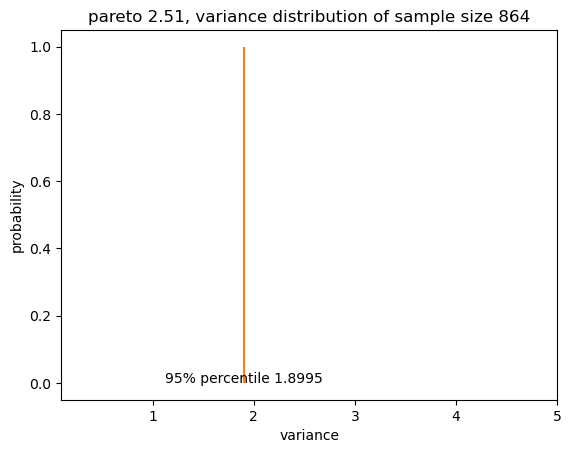

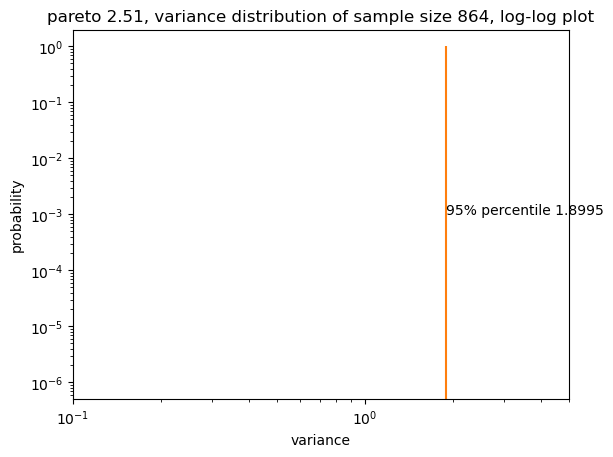

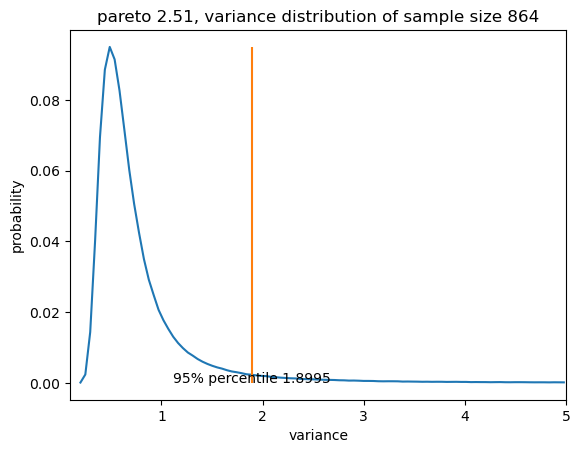

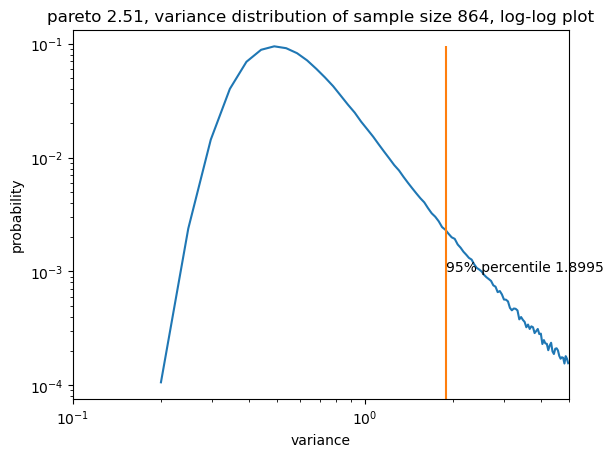

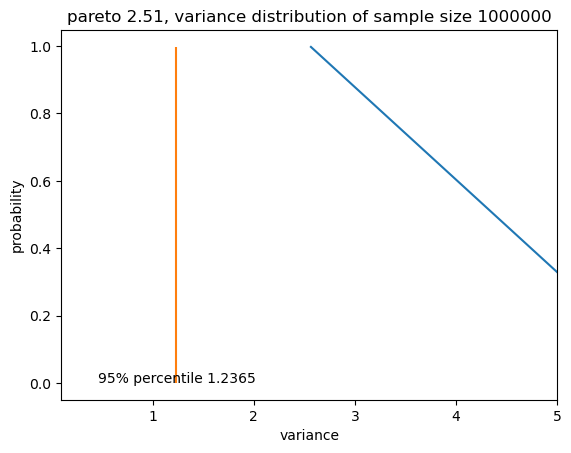

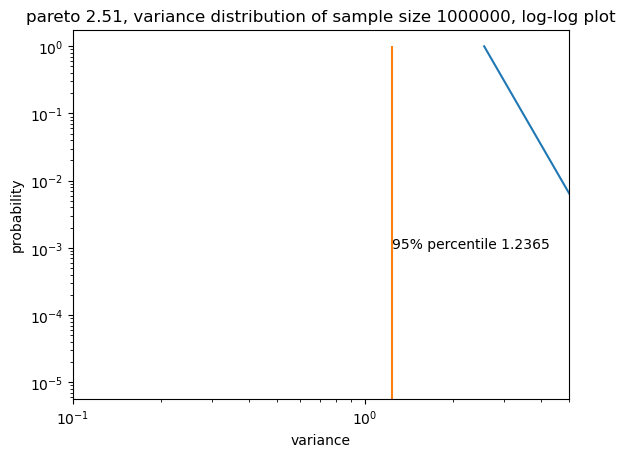

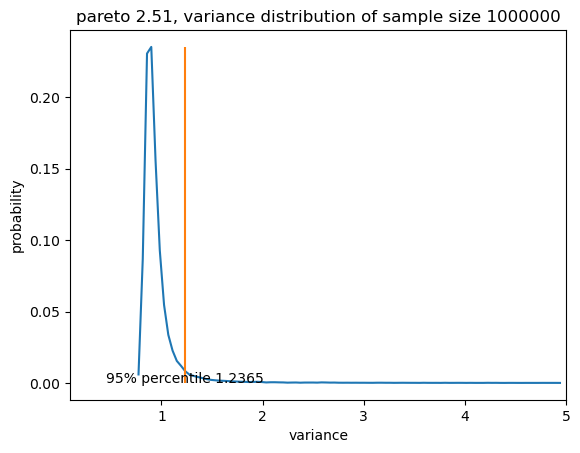

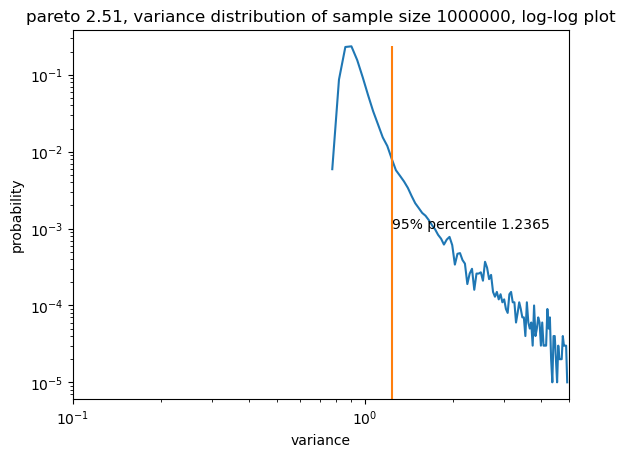

In [201]:
def paretoWithVariance(alpha):
    scale = np.sqrt((alpha-1)*(alpha-1)*(alpha-2)/alpha)
    distribution = scipy.stats.pareto(alpha, scale=scale)
    return distribution


class PDF:
    def __init__(self, x, pdf):
        self.x = x
        self.pdf = pdf


def getPDF(data, bins):
    hist = np.histogram(data, bins=bins)
    x = (hist[1][:-1] + hist[1][1:])/2
    pdf = hist[0]/len(data)
    return PDF(x, pdf)


def varianceDistribution(analysis):
    runs = 10000
    size = int(analysis.mcSize / runs)
    variance = np.zeros((runs, size))
    for i in range(runs):
        data = np.reshape(analysis.distribution.rvs(analysis.sampleSize*size), (size, analysis.sampleSize))
        variance[i] = np.var(data, axis=1)
        if (i % (runs/100)) == 0:
            print("%s run %d" % (analysis.name, i))
    variance = np.reshape(variance, analysis.mcSize)
    
    pdfAll = getPDF(variance, analysis.bins)

    # Zoom into our expected area for the chi-square distribution.
    subset = variance[variance<5]
    pdf02 = getPDF(subset, analysis.bins)
    pdf02.pdf *= len(subset) / len(variance)

    print(analysis.upperSignificance)
    upper = np.percentile(variance, analysis.upperSignificance)
    
    return ((pdfAll, pdf02), upper)


def analyze(analysis):
    print("%s variance: %f"%(analysis.name, analysis.distribution.var()))
    
    pdfs, upper = varianceDistribution(analysis)

    for pdf in pdfs:
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 0, "%d%% percentile %.4f"%(analysis.upperSignificance, upper), horizontalalignment="center")
        ax.set_xlim((1e-1, 5))
        ax.set_title("%s, variance distribution of sample size %d" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")
        
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 1e-3, "%d%% percentile %.4f"%(analysis.upperSignificance, upper))
        ax.set_xlim((1e-1, 5))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title("%s, variance distribution of sample size %d, log-log plot" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")


class Analysis:
    def __init__(self, name, sampleSize, bins, mcSize, distribution):
        self.name = name
        self.sampleSize = sampleSize
        self.bins = bins
        self.mcSize = int(bins*mcSize)
        self.distribution = distribution
        self.upperSignificance = 95


bins = 100
sampleSize = 864
analyze(Analysis("gaussian", sampleSize, bins, 1e4, scipy.stats.norm()))
alpha = 2.51
analyze(Analysis("pareto %.2f"%alpha, sampleSize, bins, 1e4, paretoWithVariance(alpha)))
analyze(Analysis("pareto %.2f"%alpha, 1000000, bins, 1e3, paretoWithVariance(alpha)))

22 0.43656949966168135 2.3650683116879923 5.417392450734184
30 0.3907653337513779 2.0129468855891677 5.151293402269642


Text(0, 0.5, 'skewness')

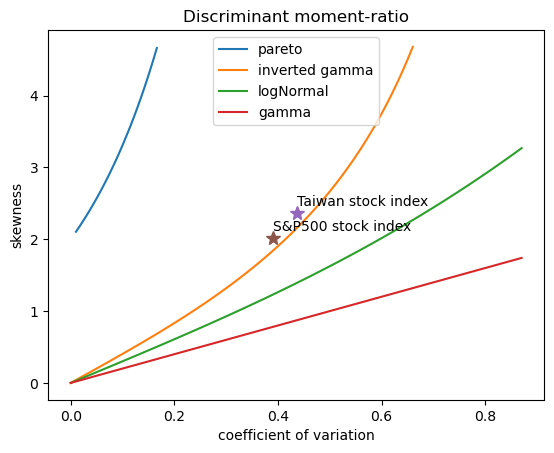

In [3]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001

        self.n = 0
        self.cv = 0
        self.skew = 0
        

def paretoCurve(maxX, maxY):
    p = np.concatenate([
        np.arange(3.01, 5, 0.01),
        np.arange(5.1, 10, 0.1),
        np.arange(10, 100, 1),
        ])
    x = 1/np.sqrt(p*(p-2))
    y = (1+p)/(p-3)*2/np.sqrt(1-2/p)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def invertedGammaCurve(maxX, maxY):
    gMaxX = min(1, maxX)
    n = 100
    
    x = np.arange(0, gMaxX-1/n, 1/n)
    y = 4*x/(1-x*x)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def logNormalCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    w = x*x + 1
    y = (w+2)*np.sqrt(w-1)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def gammaCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    y = 2*x

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def plotMomentRatio(ax, cv, skew):
    maxX = 2 * cv
    maxY = 2 * skew
    x = np.arange(0, maxX, maxX/100)
    
    pareto = paretoCurve(maxX, maxY)
    invertedGamma = invertedGammaCurve(maxX, maxY)
    logNormal = logNormalCurve(maxX, maxY)
    gamma = gammaCurve(maxX, maxY)

    ax.plot(pareto[:, 0], pareto[:, 1], label="pareto")
    ax.plot(invertedGamma[:, 0], invertedGamma[:, 1], label="inverted gamma")
    ax.plot(logNormal[:, 0], logNormal[:, 1], label="logNormal")
    ax.plot(gamma[:, 0], gamma[:, 1], label="gamma")


def analyzeMomentRatio(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    analysis.n = len(df)
    analysis.cv = np.std(df.absreturn) / np.mean(df.absreturn)
    analysis.skew = scipy.stats.skew(df.absreturn)

    print(analysis.n, analysis.cv, analysis.skew, analysis.skew/analysis.cv)


ans = []

analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 50
analysis.tailCutoff = 0.003
analyzeMomentRatio(analysis)
ans.append(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 50
analysis.tailCutoff = 0.0015
analyzeMomentRatio(analysis)
ans.append(analysis)

fig, ax = plt.subplots(1, 1)
plotMomentRatio(ax, np.max([a.cv for a in ans]), np.max([a.skew for a in ans]))
for analysis in ans:
    ax.plot(analysis.cv, analysis.skew, "*", markersize=10)
    ax.text(analysis.cv, analysis.skew+0.1, analysis.name)
ax.legend(loc="upper center")
ax.set_title("Discriminant moment-ratio")
ax.set_xlabel("coefficient of variation")
ax.set_ylabel("skewness")

65 65
61 61


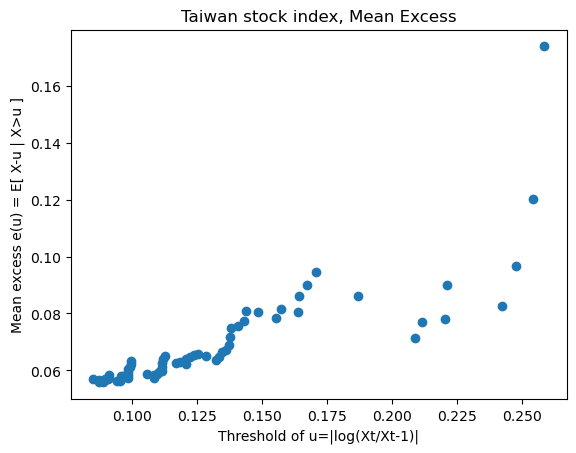

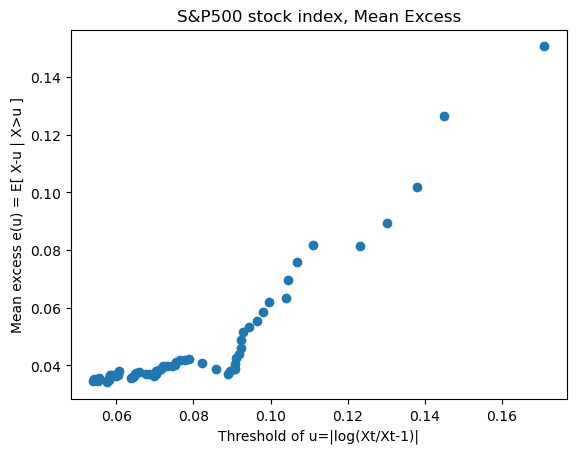

In [2]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def analyzeME(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]

    df = df.sort_values(by='date', ascending=False)
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    orderedStats = np.sort(df.absreturn)
    excessX = []
    excess = []
    for i in range(len(orderedStats)-1):
        u = orderedStats[i]
        larger = orderedStats[i+1:]
        eu = np.sum(larger-u) / len(larger)
        excessX.append(u)
        excess.append(eu)

    lastRemoveN = 1
    u = np.array(excessX)[:len(excessX)-lastRemoveN]
    eu = np.array(excess)[:len(excess)-lastRemoveN]
    print(len(u), len(eu))

    fig, ax = plt.subplots(1, 1)
    ax.plot(u, eu, "o")
    ax.set_title("%s, Mean Excess"%(analysis.name))
    ax.set_xlabel("Threshold of u=|log(Xt/Xt-1)|")
    ax.set_ylabel("Mean excess e(u) = E[ X-u | X>u ]")


lag = 18
analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = lag
analysis.tailCutoff = 0.0047
analyzeME(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = lag
analysis.tailCutoff = 0.003
analyzeME(analysis)

       i     days       date         v  numRecord
0    1.0      1.0 1967-03-14  0.038701        1.0
1    2.0     86.0 1967-06-07  0.082889        2.0
2   30.0   1604.0 1971-08-03  0.132378        3.0
3   40.0   2534.0 1974-02-18  0.211560        4.0
4   49.0   2796.0 1974-11-07  0.254138        5.0
5  145.0   7533.0 1987-10-27  0.471309        6.0
6  376.0  20757.0 2024-01-10  0.010677        6.0
       i     days       date         v  numRecord
0    1.0      1.0 1950-07-05  0.072020        1.0
1   65.0   4343.0 1962-05-25  0.099627        2.0
2   66.0   4370.0 1962-06-21  0.104110        3.0
3  136.0   8767.0 1974-07-05  0.106913        4.0
4  140.0   8921.0 1974-12-06  0.144945        5.0
5  213.0  13630.0 1987-10-28  0.340988        6.0
6  370.0  25004.0 2018-12-18  0.036908        6.0


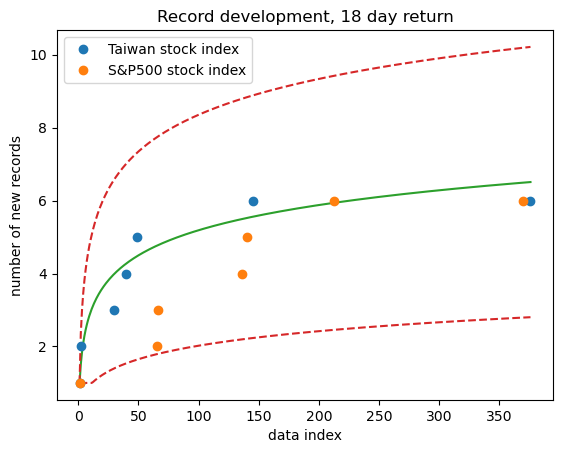

In [3]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001
        self.positive = True


def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})

    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]

    df = df.sort_values(by='date', ascending=False)
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    if analysis.positive:
        df = df[df.returns > 0]
    else:
        df = df[df.returns < 0]
    # df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    df["date"] = pandas.to_datetime(df.date)
    df = df.sort_values(by='date', ascending=True)

    return df


def recordInterval(n, ci):
    res = []
    mean = 0
    var = 0
    for i in range(int(n)):
        i1 = i + 1
        
        mean += 1/i1
        var += (1/i1 - 1/i1/i1)
        res.append((i1, mean, np.max([1, mean-ci*np.sqrt(var)]), mean+ci*np.sqrt(var)))
    return pandas.DataFrame(np.array(res), columns=("n", "mu", "ll", "ul"))


def analyzeRecord(analysis):
    df = getData(analysis)

    firstDt = df.iloc[0].date.timestamp()
    mx = -sys.float_info.max
    numRecord = 0
    records = []
    for i in range(len(df)):
        dt = df.iloc[i].date.timestamp()
        days = (dt - firstDt)/86400
        v = df.iloc[i].absreturn

        got = False
        if v > mx:
            mx = v
            numRecord += 1
            got = True

        if got or (i == len(df)-1):
            rc = [i+1, days+1, dt, v, numRecord]
            records.append(rc)
            
    records = pandas.DataFrame(np.array(records), columns=("i", "days", "date", "v", "numRecord"))
    records["date"] = records.date.astype("datetime64[s]")
    return records


def analyzeRecordList(ass):
    records = []
    for analysis in ass:
        rcs = analyzeRecord(analysis)
        records.append({"analysis": analysis, "record": rcs})

    metric = "i"
    maxX = np.max([np.max(rcs["record"][metric]) for rcs in records])
    ci = 1.96
    ci = 1.68
    theory = recordInterval(maxX, ci)
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(theory.n.to_numpy(), theory.mu.to_numpy(), color="C%d"%len(records))
    ax.plot(theory.n.to_numpy(), theory.ll.to_numpy(), "--", color="C%d"%(len(records)+1))
    ax.plot(theory.n.to_numpy(), theory.ul.to_numpy(), "--", color="C%d"%(len(records)+1))
    for i, record in enumerate(records):
        analysis = record["analysis"]
        rcs = record["record"]
        print(rcs)
        positive = "positive"
        if not analysis.positive:
            positive = "negative"
        ax.plot(rcs[metric].to_numpy(), rcs.numRecord.to_numpy(), "o", label="%s"%(analysis.name,))
    ax.legend()
    #ax.set_xscale("log")
    ax.set_title("Record development, %d day return"%(analysis.lag,))
    ax.set_xlabel("data index")
    ax.set_ylabel("number of new records")


for lag in [18]: # range(1,21):
    ass = []
    for isPositive in (False,):
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = 0.0047
        analysis.positive = isPositive
        ass.append(analysis)
        
        analysis = Analysis()
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.lag = lag
        analysis.tailCutoff = 0.003
        analysis.positive = isPositive
        ass.append(analysis)
    
    analyzeRecordList(ass)

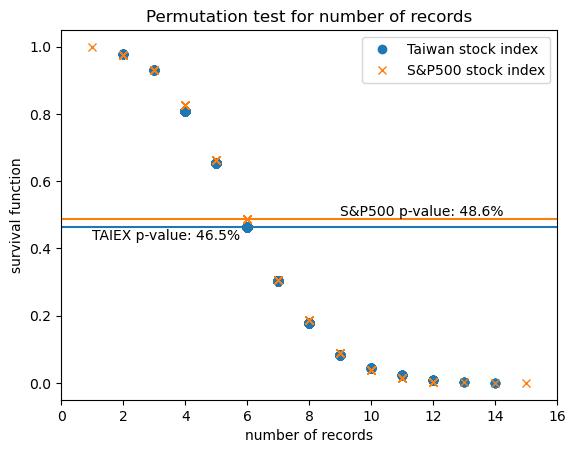

In [4]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.shortname = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001
        self.records = 0

        self.recordData = []
        self.survival = []
        self.pValue = 0
        

def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df["date"] = pandas.to_datetime(df.date)

    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]

    df["returns"] = np.log(df.price / df.price.shift(1))
    df = df.iloc[1:]

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]

    return df


def numRecords(sample):
    mx = -sys.float_info.max
    records = 0
    for d in sample:
        if d > mx:
            mx = d
            records += 1
    return records


def analyzePermRecord(analysis):
    sample = getData(analysis).absreturn.to_numpy()

    records = []
    numPermutations = 1000
    for i in range(numPermutations):
        np.random.shuffle(sample)
        rc = numRecords(sample)
        records.append(rc)

    analysis.recordData = np.sort(np.array(records))
    analysis.survival = 1 - scipy.stats.rankdata(analysis.recordData, method="max")/len(analysis.recordData)

    analysis.pValue = np.count_nonzero(analysis.recordData > analysis.records)/numPermutations

    return analysis


def analyzeShuffleRecord(ass):
    for i, analysis in enumerate(ass):
        ass[i] = analyzePermRecord(analysis)
        
    fig, ax = plt.subplots(1, 1)
    symbols = ["o", "x"]
    for i, analysis in enumerate(ass):
        ax.plot(analysis.recordData, analysis.survival, symbols[i], color="C%d"%(i,), label="%s"%(analysis.name,))
        
        ax.axhline(analysis.pValue, color="C%d"%(i,))
        upOrDown = 1
        if analysis.pValue < np.mean([a.pValue for a in ass]):
            upOrDown = -4
        ax.text(1+8*i, analysis.pValue+upOrDown*0.01, "%s p-value: %.1f%%"%(analysis.shortname, analysis.pValue*100))
        
    maxX = np.max([np.max(a.recordData) for a in ass])
    ax.set_xlim((0, maxX+1))
    ax.legend()
    ax.set_title("Permutation test for number of records")
    ax.set_xlabel("number of records")
    ax.set_ylabel("survival function")


ass = []

analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.shortname = "TAIEX"
analysis.fpath = "taiex.csv"
analysis.lag = 18
analysis.tailCutoff = 0.0047
analysis.records = 6
ass.append(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.shortname = "S&P500"
analysis.fpath = "sp500.csv"
analysis.lag = 18
analysis.tailCutoff = 0.003
analysis.records = 6
ass.append(analysis)

analyzeShuffleRecord(ass)

18 0.0047
18 0.003


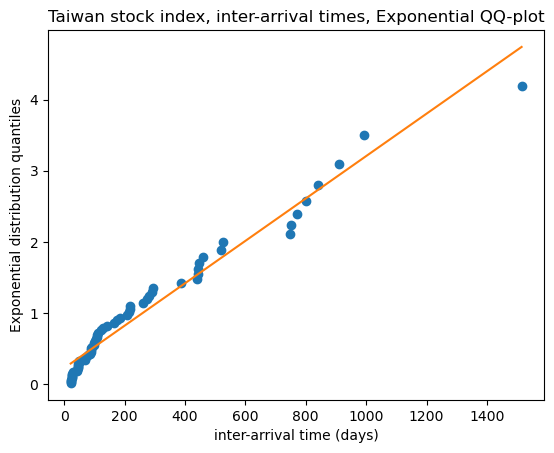

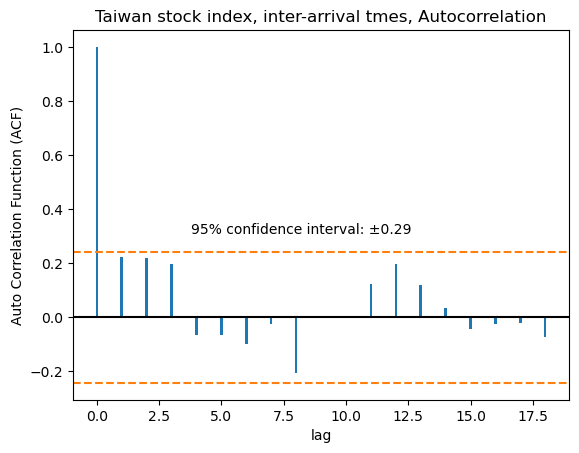

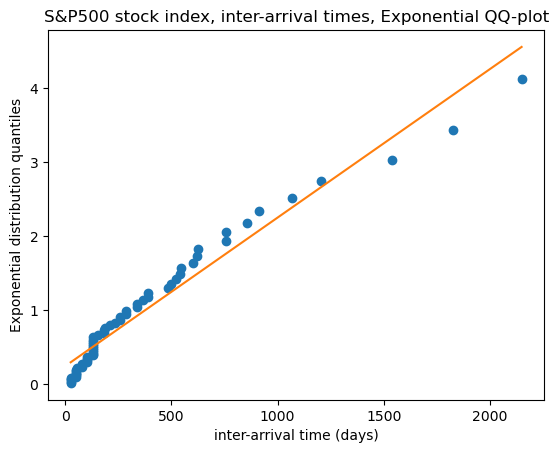

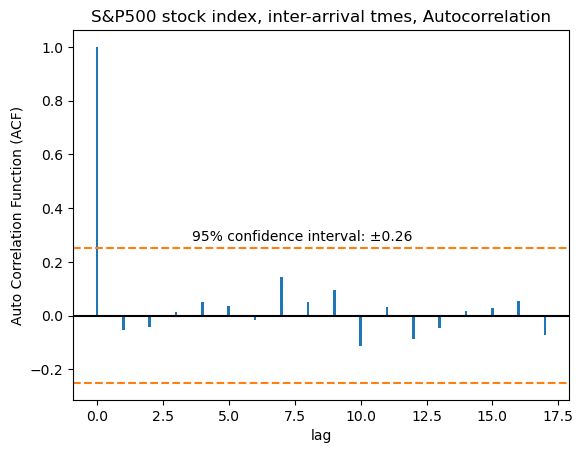

In [5]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})

    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]

    df = df.sort_values(by='date', ascending=False)
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    df["date"] = pandas.to_datetime(df.date)
    
    return df


def analyzeArrival(analysis, df):
    # Compute inter-arrival times
    df = df.sort_values(by='date', ascending=True)
    df["days"] = (df.date - df.date.shift(1)).dt.days
    df = df.iloc[1:]

    # Compute quantiles
    df = df.sort_values(by="days", ascending=True)
    df["q"] = df.days.rank(pct=True, method="average")
    df["q"] = (np.arange(len(df))+1)/len(df)
    #df = df.iloc[1:]
    df = df.iloc[:-1]

    # Compute theory
    df["exponential"] = scipy.stats.expon(scale=1).ppf(df.q)
    linres = scipy.stats.linregress(df.days, df.exponential)
    df["exponLin"] = linres.intercept + linres.slope*df.days

    return df


def analyzeArrivalTime(ass):
    records = []
    for analysis in ass:
        print(analysis.lag, analysis.tailCutoff)
        df = getData(analysis)
        if len(df) < 10:
            continue
        rcs = analyzeArrival(analysis, df)
        records.append({"analysis": analysis, "record": rcs})

    for i, record in enumerate(records):
        analysis = record["analysis"]
        rcs = record["record"]
        
        # with pandas.option_context('display.max_rows', None):
        #     print(rcs.iloc[200:])
        fig, ax = plt.subplots(1, 1)
        positive = "positive"
        if not analysis.positive:
            positive = "negative"
        ax.plot(rcs.days.to_numpy(), rcs.exponential.to_numpy(), "o", label="%s"%(analysis.name,))
        ax.plot(rcs.days.to_numpy(), rcs.exponLin.to_numpy())
        #ax.legend()
        #ax.set_xscale("log")
        ax.set_title("%s, inter-arrival times, Exponential QQ-plot"%(analysis.name,))
        ax.set_xlabel("inter-arrival time (days)")
        ax.set_ylabel("Exponential distribution quantiles")

        quantities = [{"name": "inter-arrival tmes", "col": "days"}, {"name": "log returns", "col": "absreturn"}]
        for q in quantities[:1]:
            vs = rcs.sort_values(by='date', ascending=True)[q["col"]]
            
            acs1 = [vs.autocorr(i) for i in range(int(10*np.log10(len(vs))))]
            confidence = 95
            interval1 = scipy.stats.norm.ppf(1 - (1-confidence/100.0) / 2.0) * np.sqrt(1/len(vs))
            
            acs2, confint, qstat, pvals = statsmodels.tsa.stattools.acf(vs, alpha=1-confidence/100.0, qstat=True, fft=True)
            #print(acs2, confint, qstat, pvals)
            interval2 = (confint[1:, 1] - confint[1:, 0])/2
            

            fig, ax = plt.subplots(1, 1)
            ax.axhline(interval1, linestyle="--", color="C1")
            ax.axhline(-interval1, linestyle="--", color="C1")
            #ax.plot(np.arange(1, len(acs2), 1), interval2, linestyle="--", color="C1")
            #ax.plot(np.arange(1, len(acs2), 1), -interval2, linestyle="--", color="C1")
            #ax.plot(np.arange(0, len(acs1), 1), acs1, "o")
            ax.axhline(0, linestyle="-", color="black")
            ax.bar(np.arange(0, len(acs2), 1), acs2, width=0.1)
            itv = interval2[int(len(interval2)/2)]
            ax.text(len(acs2)/5, itv+0.02, ("%d%% confidence interval: ±%.2f"%(confidence, itv)))
            ax.set_title("%s, %s, Autocorrelation"%(analysis.name, q["name"]))
            ax.set_xlabel("lag")
            ax.set_ylabel("Auto Correlation Function (ACF)")


ass = []
for lag in [18]:
    for tailCutoff in [0.0047]: # np.arange(0.001, 0.0075, 0.0001):
        for isPositive in (False,):
            analysis = Analysis()
            analysis.name = "Taiwan stock index"
            analysis.fpath = "taiex.csv"
            analysis.lag = lag
            analysis.tailCutoff = tailCutoff
            analysis.positive = isPositive
            ass.append(analysis)
            
            analysis = Analysis()
            analysis.name = "S&P500 stock index"
            analysis.fpath = "sp500.csv"
            analysis.lag = lag
            analysis.tailCutoff = 0.003
            analysis.positive = isPositive
            ass.append(analysis)
    
analyzeArrivalTime(ass)

In [19]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.cutoff = 0.1
        

def analyzeMeanArrival(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df["date"] = pandas.to_datetime(df.date)

    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]

    # Calculate returns.
    df = df.sort_values(by='date', ascending=False)
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    # Filter for tail.
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.cutoff)]

    # Calculate inter-arrival times.
    df = df.sort_values(by='date', ascending=True)
    df["days"] = (df.date - df.date.shift(1)).dt.days
    df = df.iloc[1:]

    print("%s, %d%% inter-arrival: %.2f days %f"%(analysis.name, int(analysis.cutoff*100), np.mean(df.days), np.sqrt(np.var(df.days))))
    df = df.sort_values(by="date", ascending=True)
    print(df)


ass = []

lag = 18
analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = lag
ass.append(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = lag
ass.append(analysis)

for a in ass:
    analyzeMeanArrival(a)

Taiwan stock index, 10% inter-arrival: 415.49 days 679.638977
            date     price   returns  absreturn    days
13467 1974-02-18    399.78 -0.211560   0.211560   930.0
13377 1974-06-05    343.01 -0.128515   0.128515   107.0
13305 1974-08-31    303.28 -0.164255   0.164255    87.0
13269 1974-10-16    254.35 -0.148501   0.148501    46.0
13251 1974-11-07    197.27 -0.254138   0.254138    22.0
13215 1974-12-21    188.74 -0.138190   0.138190    44.0
13071 1975-06-25    355.68 -0.134561   0.134561   186.0
12693 1976-10-12    268.07 -0.137422   0.137422   475.0
12081 1978-11-21    569.87 -0.122275   0.122275   770.0
9489  1987-10-27   2836.92 -0.471309   0.471309  3262.0
9435  1988-01-08   2480.33 -0.109585   0.109585    73.0
9201  1988-10-28   6153.00 -0.208750   0.208750   294.0
9165  1988-12-14   5999.26 -0.221265   0.221265    47.0
9003  1989-07-11   7930.00 -0.242377   0.242377   209.0
8877  1989-12-14   8427.00 -0.170644   0.170644   156.0
8787  1990-04-16   9419.00 -0.120763   0.1

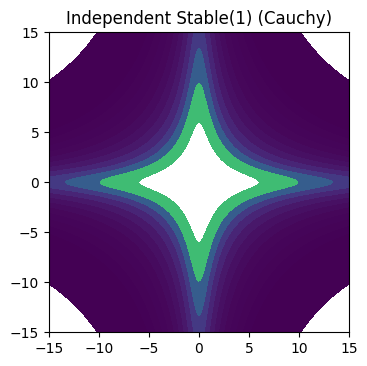

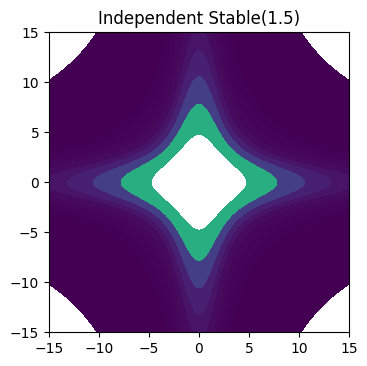

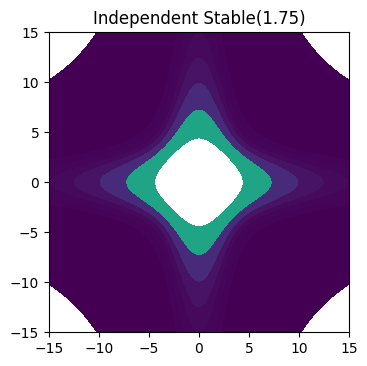

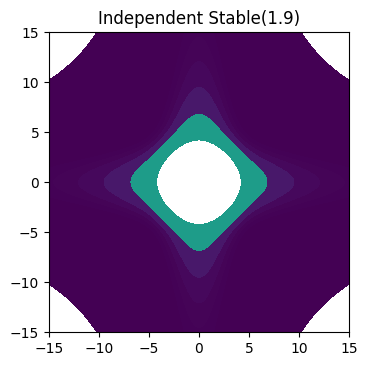

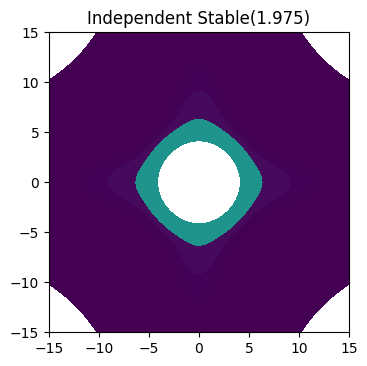

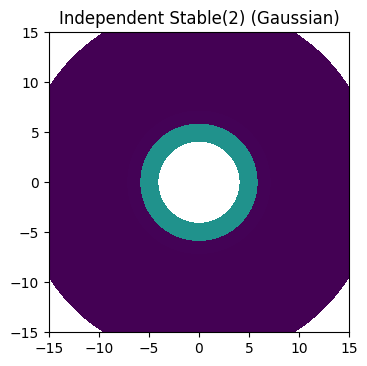

In [86]:
def set_size(ax, w, h):
    """ w, h: width, height in inches """
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    

def plot_contour(xs, ys, zs, levels, title):
    fig, ax = plt.subplots(1, 1)
    set_size(ax, 3, 3)
    ax.contourf(xs, ys, zs, levels=levels)
    ax.set_title(title)
    if False:
        fig, ax = plt.subplots(1, 1)
        ax.axhline(interval1, linestyle="--", color="C1")
        ax.axhline(-interval1, linestyle="--", color="C1")
        #ax.plot(np.arange(1, len(acs2), 1), interval2, linestyle="--", color="C1")
        #ax.plot(np.arange(1, len(acs2), 1), -interval2, linestyle="--", color="C1")
        #ax.plot(np.arange(0, len(acs1), 1), acs1, "o")
        ax.axhline(0, linestyle="-", color="black")
        ax.bar(np.arange(0, len(acs2), 1), acs2, width=0.1)
        itv = interval2[int(len(interval2)/2)]
        ax.text(len(acs2)/5, itv+0.02, ("%d%% confidence interval: ±%.2f"%(confidence, itv)))
        ax.set_title("%s, %s, Autocorrelation"%(analysis.name, q["name"]))
        ax.set_xlabel("lag")
        ax.set_ylabel("Auto Correlation Function (ACF)")


def product(fn, xs, ys):
    fx = fn(xs)
    fy = fn(ys)
    zs = fx.reshape([fx.shape[0], 1]) @ fy.reshape([1, fx.shape[0]])
    return zs
    

maxX = 15
grid_size = 1000
xs = np.linspace(-maxX, maxX, grid_size)
ys = np.linspace(-maxX, maxX, grid_size)
alphas = [1, 1.5, 1.75, 1.9, 1.975, 2]
for alpha in alphas:
    beta = 0
    zs = product(lambda x: scipy.stats.levy_stable.pdf(x, alpha, beta), xs, ys)

    numLevels = 16
    
    # Equal height levels, the default of matplotlib.pyplot.contour.
    levels = np.linspace(z[0], z[-1], numLevels+2)[1:-1]

    # Equal support levels.
    z = np.sort(zs.reshape([-1]))
    zidx = [int(x) for x in np.linspace(0, z.shape[0], numLevels+2)[1:-1]]
    levels = z[zidx]

    suffix = ""
    if alpha == 1:
        suffix = " (Cauchy)"
    if alpha == 2:
        suffix = " (Gaussian)"
    plot_contour(xs, ys, zs, levels, "Independent Stable({}){}".format(alpha, suffix))

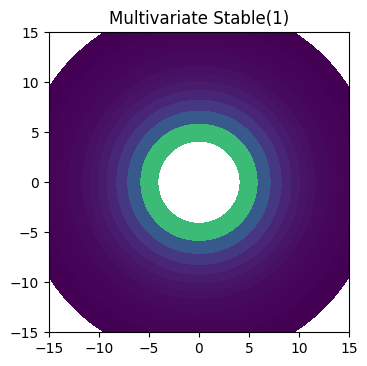

In [85]:
def map_grid(fn, xs, ys):
    zs = np.zeros([xs.shape[0], ys.shape[0]])
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            zs[i, j] = fn(x, y)
    return zs


def cauchy(x, y):
    return 1.0/(2*np.pi) * (1.0/np.pow(x*x+y*y+1, 3.0/2))


maxX = 15
grid_size = 1000
xs = np.linspace(-maxX, maxX, grid_size)
ys = np.linspace(-maxX, maxX, grid_size)
alpha = 1
beta = 0
zs = map_grid(lambda x, y: cauchy(x, y), xs, ys)

numLevels = 16
    
# Equal height levels, the default of matplotlib.pyplot.contour.
levels = np.linspace(z[0], z[-1], numLevels+2)[1:-1]

# Equal support levels.
z = np.sort(zs.reshape([-1]))
zidx = [int(x) for x in np.linspace(0, z.shape[0], numLevels+2)[1:-1]]
levels = z[zidx]

plot_contour(xs, ys, zs, levels, "Multivariate Stable({})".format(alpha))